# Spatial-Temporal Graph Neural Network (Spatial-Temporal GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using Openpose in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [1]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

C:\Users\Abel\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Abel\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Abel\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Dataset

## Training dataset

In [2]:
info = 2

train_dataset = SkeletonsDataset('Data/train_annotations_with_skeletons.csv',
                                 normalization='minmax', target='cross', info=info)

print('train_dataset len:', len(train_dataset))
print('Temporal dimension length:', len(train_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', train_dataset.data[0].x_temporal[0].shape)

train_dataset.loadedData

train_dataset len: 34018
Temporal dimension length: 2
Shape of each skeletons data (x): torch.Size([25, 3])


,Unnamed: 0,video,id,frame,occluded,outside,x2,y2,x1,y1,...,pose_front,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected
0,5564,video_0041,0_41_197b,0,0,0,1372.0,740.0,1345.0,651.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.23, 668.429, 0.207086], [1354.37, 668.6...",True
1,5565,video_0041,0_41_197b,1,0,0,1372.0,740.0,1343.0,651.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.24, 668.672, 0.135277], [1354.33, 671.4...",True
2,5566,video_0041,0_41_197b,2,0,0,1371.0,741.0,1341.0,652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1351.7, 668.601, 0.128466], [1354.19, 671.40...",True
3,5567,video_0041,0_41_197b,3,0,0,1371.0,741.0,1339.0,652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.15, 668.701, 0.10925], [1354.14, 671.54...",True
4,5568,video_0041,0_41_197b,4,0,0,1371.0,742.0,1337.0,653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.12, 668.759, 0.104457], [1351.68, 671.6...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,44967,video_0278,0_278_2189b,115,0,0,1135.0,868.0,1029.0,642.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True
39404,44968,video_0278,0_278_2189b,116,0,0,1151.0,874.0,1044.0,643.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True
39405,44969,video_0278,0_278_2189b,117,0,0,1167.0,880.0,1058.0,643.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True
39406,44970,video_0278,0_278_2189b,118,0,0,1183.0,886.0,1073.0,644.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True


Important columns:

In [3]:
train_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,crossing
0,video_0041,0,-1,"[[1354.23, 668.429, 0.207086], [1354.37, 668.6...",True,1
1,video_0041,1,-1,"[[1354.24, 668.672, 0.135277], [1354.33, 671.4...",True,1
2,video_0041,2,-1,"[[1351.7, 668.601, 0.128466], [1354.19, 671.40...",True,1
3,video_0041,3,-1,"[[1354.15, 668.701, 0.10925], [1354.14, 671.54...",True,1
4,video_0041,4,-1,"[[1354.12, 668.759, 0.104457], [1351.68, 671.6...",True,1
...,...,...,...,...,...,...
39403,video_0278,115,-1,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True,1
39404,video_0278,116,-1,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True,1
39405,video_0278,117,-1,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True,1
39406,video_0278,118,-1,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True,1


Number of elements per class:

Training dataset total rows: 34180
Training dataset crossing class samples: 25615
Training dataset not-crossing class samples: 8565


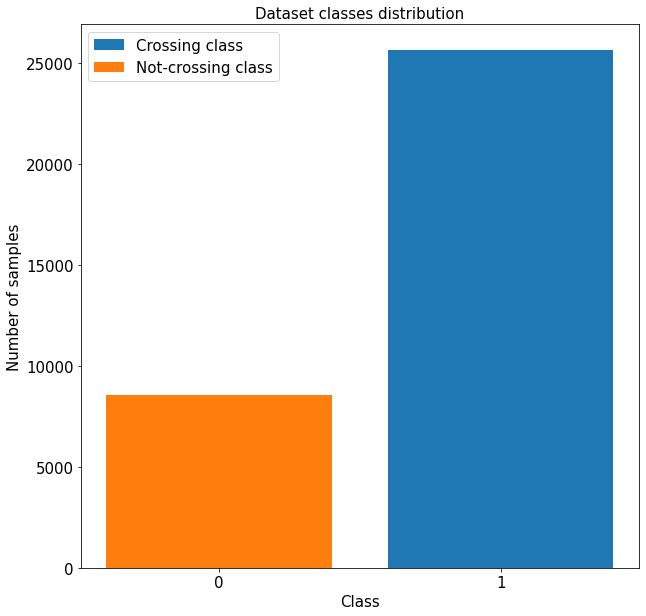

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['crossing']==1])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['crossing']!=1])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

## Showing a skeleton

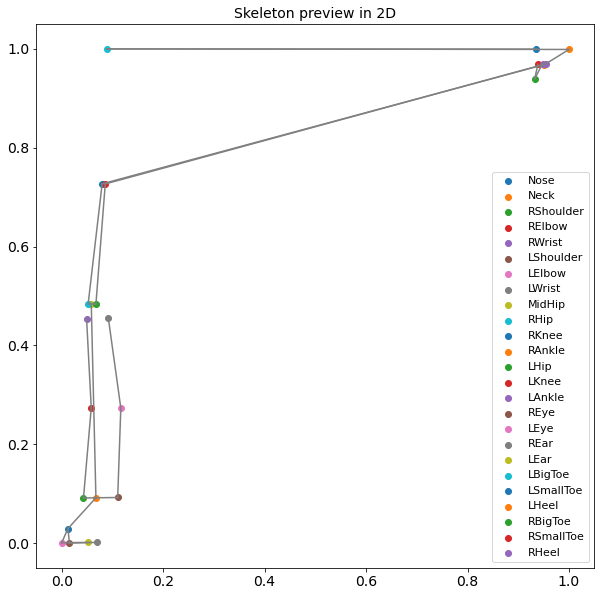

In [5]:
textsize = 14
body_parts = train_dataset.body_parts
pose_parts = train_dataset.pose_parts
parts = list(body_parts.keys())

node_coords = {}

plt.figure(figsize=(10,10))

skeleton = train_dataset.data[100].x_temporal[0][:, 0:2].tolist()

for e, sk in enumerate(skeleton):    
    node_coords[parts[e]] = sk
    
    plt.scatter(sk[0], sk[1], label=parts[e])

for edge in pose_parts:
    e0 = node_coords[edge[0]]
    e1 = node_coords[edge[1]]
    
    plt.plot([e0[0], e1[0]], [e0[1], e1[1]], color='gray')

plt.legend(loc='best', prop={'size': 11})
plt.xticks(size=textsize)
plt.yticks(size=textsize)
plt.title('Skeleton preview in 2D', size=textsize)
plt.show()

## Validation dataset

In [6]:
val_dataset = SkeletonsDataset('Data/val_annotations_with_skeletons.csv', normalization='minmax',
                               target='cross', info=info)

val_dataset.shuffle()

In [7]:
print('val_dataset len:', len(val_dataset))
print('Temporal dimension length:', len(val_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', val_dataset.data[0].x_temporal[0].shape)

val_dataset.loadedData

val_dataset len: 4197
Temporal dimension length: 2
Shape of each skeletons data (x): torch.Size([25, 3])


,video,id,frame,occluded,outside,x2,y2,x1,y1,age,...,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected,outputs
0,video_0280,0_280_2201b,0,0,0,641.0,846.0,618.0,772.0,adult,...,0,1,0,0,0,moving_fast,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,"[[631.0001220703125, 622.58251953125], [629.85..."
65,video_0280,0_280_2201b,65,0,0,640.0,882.0,569.0,763.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,"[[617.3148803710938, 615.83544921875], [616.56..."
66,video_0280,0_280_2201b,66,0,0,640.0,883.0,571.0,764.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,"[[588.305419921875, 612.5685424804688], [587.1..."
67,video_0280,0_280_2201b,67,0,0,640.0,883.0,572.0,765.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,"[[587.4631958007812, 628.0204467773438], [585...."
68,video_0280,0_280_2201b,68,0,0,640.0,884.0,574.0,766.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,"[[577.976318359375, 622.7041625976562], [576.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,video_0312,0_312_2449b,115,0,0,458.0,983.0,278.0,623.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,"[[372.368408203125, 659.8908081054688], [369.7..."
5268,video_0312,0_312_2449b,116,0,0,441.0,992.0,252.0,622.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,"[[350.1001892089844, 637.2662963867188], [345...."
5269,video_0312,0_312_2449b,117,0,0,424.0,1000.0,226.0,620.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,"[[317.420654296875, 643.6817626953125], [312.8..."
5270,video_0312,0_312_2449b,118,0,0,396.0,1015.0,201.0,619.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,"[[283.4302978515625, 642.0805053710938], [280...."


Important columns:

In [8]:
val_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,crossing
0,video_0280,0,33,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,1
65,video_0280,65,33,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,1
66,video_0280,66,33,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,1
67,video_0280,67,33,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,1
68,video_0280,68,33,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,1
...,...,...,...,...,...,...
5267,video_0312,115,-1,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,1
5268,video_0312,116,-1,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,1
5269,video_0312,117,-1,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,1
5270,video_0312,118,-1,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,1


Number of elements per class:

Validation dataset total rows: 4223
Validation dataset crossing class samples: 2609
Validation dataset not-crossing class samples: 1614


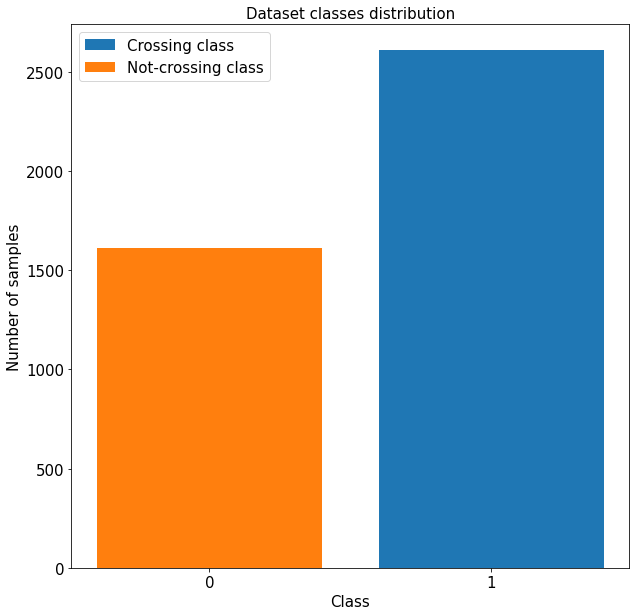

In [9]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['crossing']==1])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['crossing']!=1])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

## Showing a skeleton

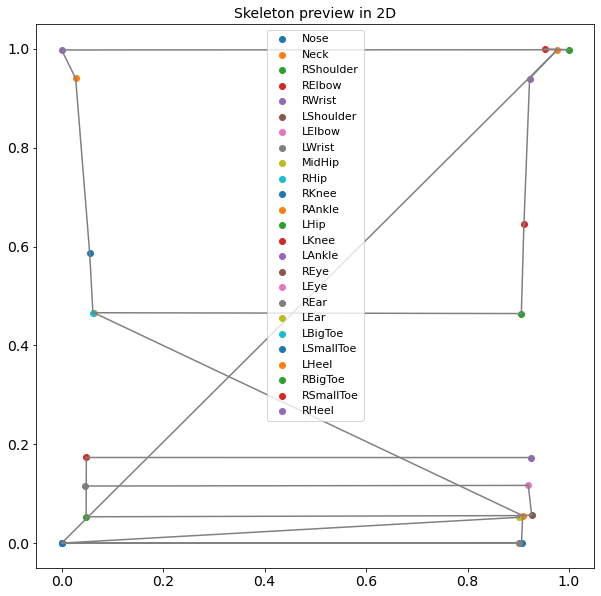

In [10]:
textsize = 14
body_parts = val_dataset.body_parts
pose_parts = val_dataset.pose_parts
parts = list(body_parts.keys())

node_coords = {}

plt.figure(figsize=(10,10))

skeleton = val_dataset.data[0].x_temporal[0][:, 0:2].tolist()

for e, sk in enumerate(skeleton):    
    node_coords[parts[e]] = sk
    
    plt.scatter(sk[0], sk[1], label=parts[e])

for edge in pose_parts:
    e0 = node_coords[edge[0]]
    e1 = node_coords[edge[1]]
    
    plt.plot([e0[0], e1[0]], [e0[1], e1[1]], color='gray')

plt.legend(loc='best', prop={'size': 11})
plt.xticks(size=textsize)
plt.yticks(size=textsize)
plt.title('Skeleton preview in 2D', size=textsize)
plt.show()

# Training

In [11]:
numberOfClasses = 2

y = train_dataset.loadedData['crossing'].to_numpy()
y = np.where(y==1, 1, 0)
bc = np.bincount(y)

class_weights = len(train_dataset.loadedData) / (numberOfClasses * bc)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('class_weights:', class_weights)

class_weights: tensor([1.9953, 0.6672])


In [12]:
train_dataset.shuffle()

In [13]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x_temporal[0]

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 25
Number of features per node: 3


In [14]:
num_epochs = 25
batch_size = 500

device = torch.device('cpu')
model = SpatialTemporalGNN(embed_dim, numberOfClasses, numberOfNodes, net='GConvGRU', filterSize=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()#weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

metrics_train = []
metrics_val = []

for epoch in range(num_epochs):

    train_loss = train(model, train_loader, device, optimizer, crit)
    loss_values.append(train_loss)

    train_metrics = evaluate(model, train_loader, device, computed_loss=train_loss)
    val_metrics = evaluate(model, val_loader, device, loss_crit=crit)

    metrics_train.append(train_metrics)
    metrics_val.append(val_metrics)
    
    if num_epochs <= 25:
        
        print_evaluation_train_val(epoch, train_metrics, val_metrics)

Epoch:                           001
Train Loss:                   0.6648  -  Validation Loss:                   0.7249
Train Accuracy:               0.6528  -  Validation Accuracy:               0.4496
Train Balanced accuracy:      0.6079  -  Validation Balanced accuracy:      0.5522
Train Precision:              0.6344  -  Validation Precision:              0.3965
Train Recall:                 0.9247  -  Validation Recall:                 0.9432
Train f1-score:               0.7526  -  Validation f1-score:               0.5583
 


Epoch:                           002
Train Loss:                   0.6362  -  Validation Loss:                   0.6952
Train Accuracy:               0.6781  -  Validation Accuracy:               0.4796
Train Balanced accuracy:      0.6404  -  Validation Balanced accuracy:      0.5757
Train Precision:              0.6585  -  Validation Precision:              0.4105
Train Recall:                 0.9061  -  Validation Recall:                 0.9419
Train f1-

Epoch:                           017
Train Loss:                   0.5874  -  Validation Loss:                   0.6197
Train Accuracy:               0.7144  -  Validation Accuracy:               0.5759
Train Balanced accuracy:      0.6889  -  Validation Balanced accuracy:      0.6415
Train Precision:              0.7019  -  Validation Precision:              0.4612
Train Recall:                 0.8688  -  Validation Recall:                 0.8915
Train f1-score:               0.7765  -  Validation f1-score:               0.6079
 


Epoch:                           018
Train Loss:                   0.5850  -  Validation Loss:                   0.6154
Train Accuracy:               0.7153  -  Validation Accuracy:               0.5761
Train Balanced accuracy:      0.6907  -  Validation Balanced accuracy:      0.6430
Train Precision:              0.7043  -  Validation Precision:              0.4616
Train Recall:                 0.8644  -  Validation Recall:                 0.8979
Train f1-

## Model performance plots

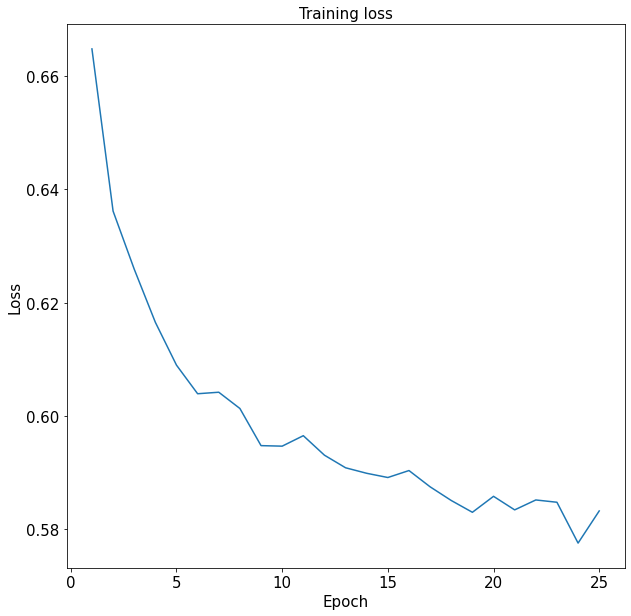

In [15]:
plot_loss(num_epochs, loss_values, figsize=10, textsize=15)

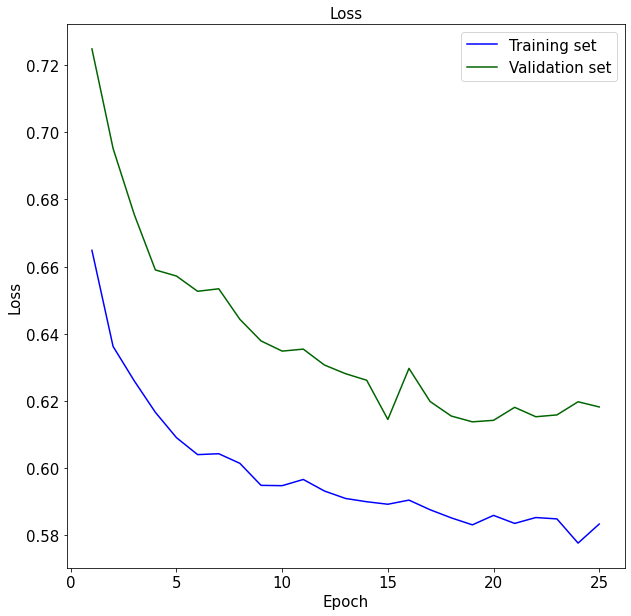

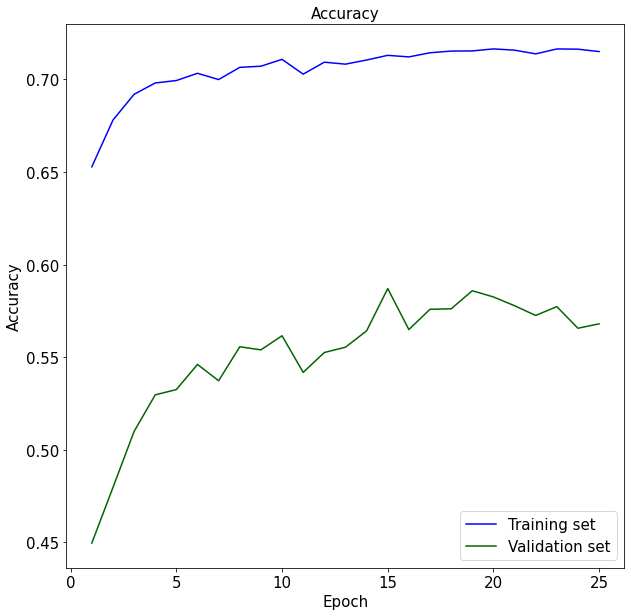

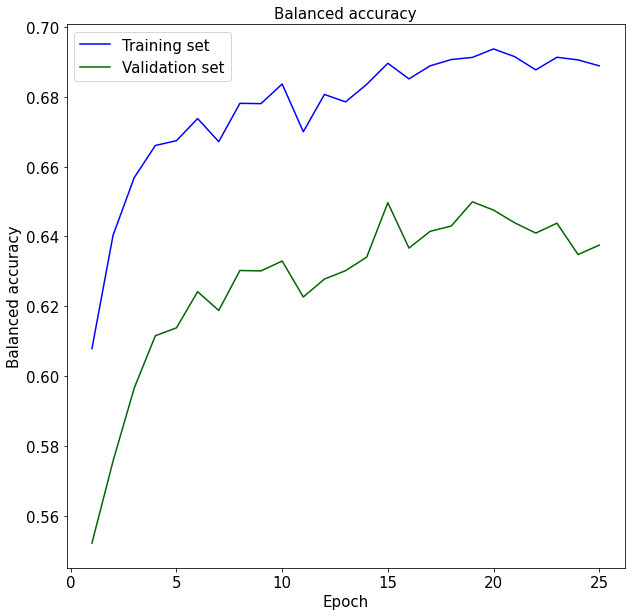

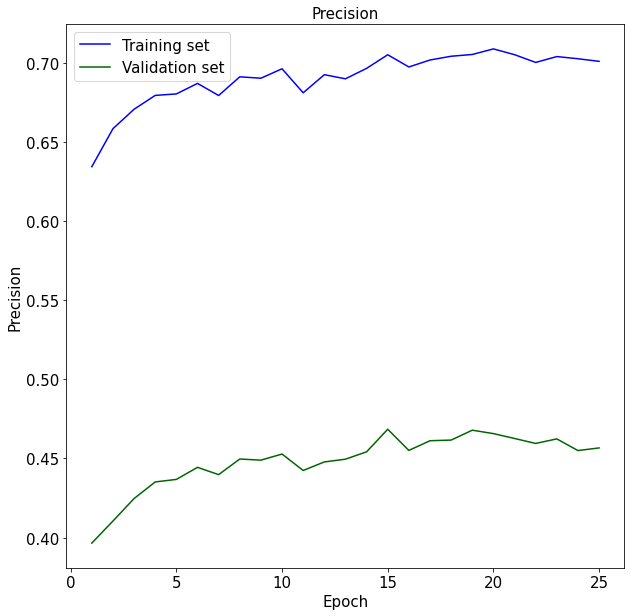

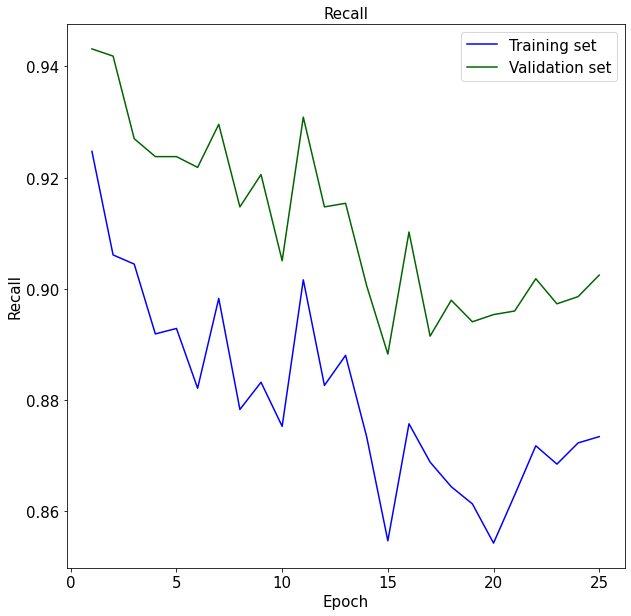

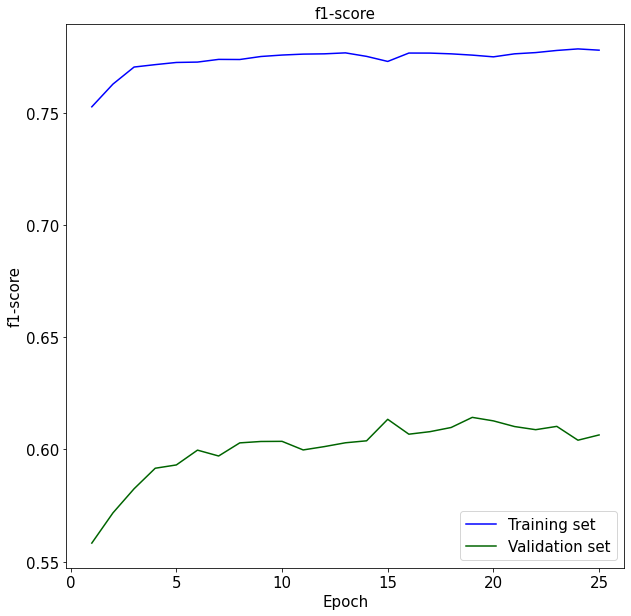

In [16]:
plot_classification_metrics_train_val(num_epochs, metrics_train, metrics_val, figsize=10, textsize=15)

## ROC curves

### Train set

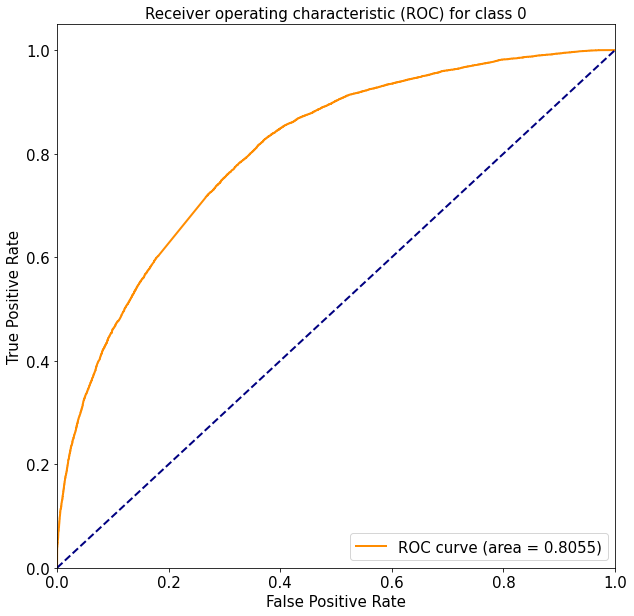

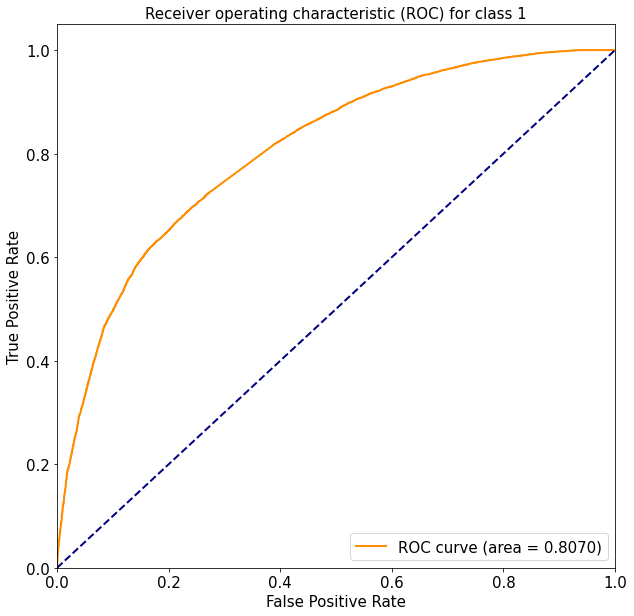

In [17]:
fpr, tpr, roc_auc = ROC(model, train_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

### Validation set

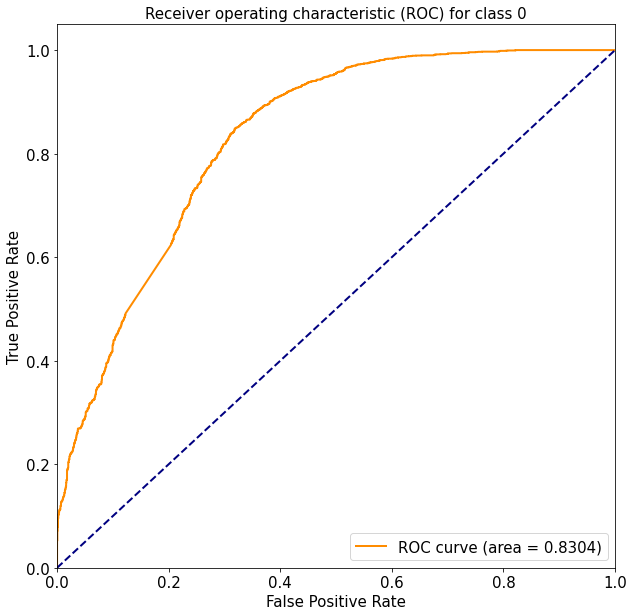

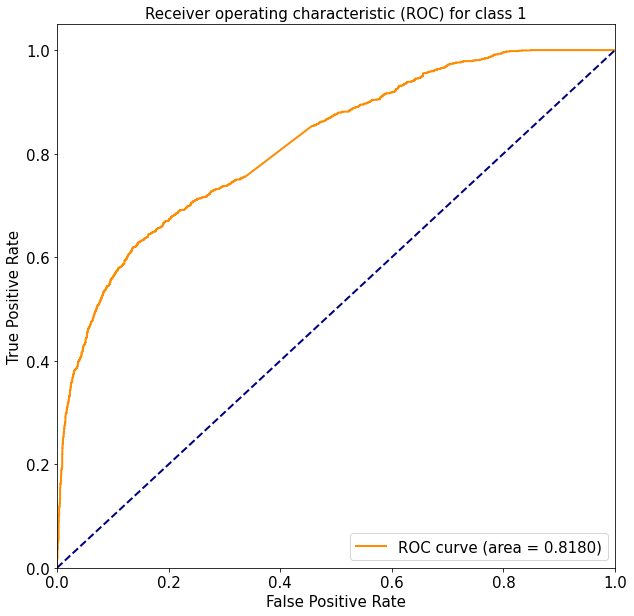

In [18]:
fpr, tpr, roc_auc = ROC(model, val_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

# Testing

## Test dataset

In [19]:
test_dataset = SkeletonsDataset('Data/test_annotations_with_skeletons.csv', normalization='minmax',
                               target='cross', info=info)

test_dataset.shuffle()

Number of elements per class:

Test dataset total rows: 4633
Test dataset crossing class samples: 2402
Test dataset not-crossing class samples: 2231


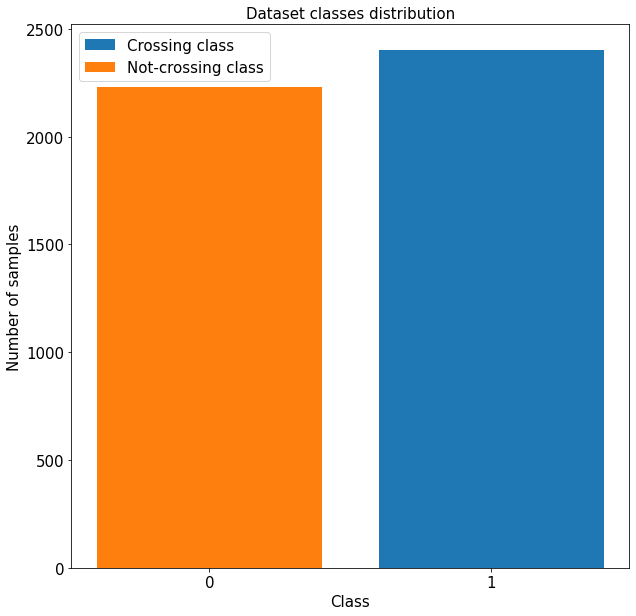

In [20]:
totalRows = len(test_dataset.loadedData)
crossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='not-crossing'])

print('Test dataset total rows:', totalRows)
print('Test dataset crossing class samples:', crossingRows)
print('Test dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

## Test results

In [21]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_metrics = evaluate(model, test_loader, device)


print_evaluation_test(test_metrics)

Testing subset results:

Accuracy:                 0.6608
Balanced accuracy:        0.6532
Precision:                0.6389
Recall:                   0.8116
f1-score:                 0.7149
 


